In [43]:
'''
Steps: 
1. Import data from ../data/day1, ../data/day2
2. 

'''

'\nSteps: \n1. Import data from ../data/day1, ../data/day2\n2. \n\n'

In [44]:
# Imports
import numpy as np
import scipy
import pickle
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import random


from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [46]:
'''
This cell opens the pickled data and converts it into an array where each entry is a single
trial's tracking data.
'''
in_pickle = open('../data/readings.pkl', 'rb')
main_dict = pickle.load(in_pickle)
main_dict.keys()
len(main_dict['day2'])

# Array to populate with each trial's sub-arrays
full_array = []

# Getting day1 and day2 data into the same array
for i in main_dict['day1']:
    full_array += [i]
for i in main_dict['day2']:
    full_array += [i]

# Outputting statistics on the final array
print('Number of trials: {}'.format(len(full_array)))
print('Number of samples per trial: {}'.format(len(full_array[0])))

Number of trials: 59
Number of samples per trial: 120


In [47]:
'''
This cell takes in the full array of all the trials and filters out the invalid ones where tracking is lost.
It also outputs how many were clean and dirty.

It also scales the data so that measurements are now in um (micrometers)
'''

clean_data = [] # This array will exclude trials with bad data in them

# Function to get tell you if data from a given trial is valid or invalid.
def validate_trial(trial):
    for i in range(0, len(trial)-1):
        if(trial[i][0] == 0 and trial[i][1] == 0):
            return False
    return True

# Getting count for how much good/bad data you have
num_good = 0
for i in full_array:
    if validate_trial(i):
        num_good += 1

print('Valid trial rate is: {}/{}'.format(num_good, len(full_array)))

# Adding good data to the `clean_data` array
for i in range(0, len(full_array)):
    if validate_trial(full_array[i]):
        clean_data += [full_array[i]]

# Scaling the data.
for i in range(0, len(clean_data)):
    for j in range(0, len(clean_data[i])):
        clean_data[i][j] = clean_data[i][j]*0.1155
        

print('New size of valid trials is {}'.format(len(clean_data)))

Valid trial rate is: 41/59
New size of valid trials is 41


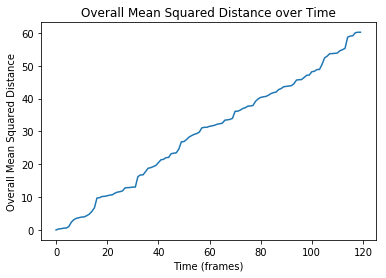

Max dr_dt value: 12.494471404701374
Mean dr_dt value: 0.3514626492632869


In [48]:
'''
This cell creates an array of the distance traveled between every data entry for each trial.
It also calculates the mean squared distance over time for each trial.

Plots:
    1. dr/dt values over time.
    2. The first trial's mean squared distance over time. Should be roughly linear.
'''
# Processing each clean trial: 
# 1. Calculate distance traveled between each point in time (dr/dt) for all data sets.
# 2. Compile results into a single 1-d array

dr_dt = []
mean_squared_distances = [];

for i in clean_data:
    add_msd = [0] # for each trial, we have a sub-array for the mean squared distances
    for j in range(1, len(i)):
        dx = i[j][0]-i[j-1][0]
        dy = i[j][1]-i[j-1][1]
        dr = math.sqrt(dx**2 + dy**2)
#         print("Point {}".format(dr))
        if dr < 20:
            dr_dt += [dr]
            add_msd += [add_msd[len(add_msd)-1] + dr*dr] # adding to the mean squared distances 
                                                         # sub-array for this trial
    mean_squared_distances += [add_msd] # Adding the mean squared distance sub-array to the main array

plt.plot(dr_dt)
plt.xlabel('time')
plt.ylabel('dr')
plt.title('dR values vs. Time')
plt.show()

# plt.plot(msd_avg)
plt.plot(mean_squared_distances[0])
plt.xlabel('Time (frames)')
plt.ylabel('Overall Mean Squared Distance')
plt.title('Overall Mean Squared Distance over Time')
plt.show()

print('Max dr_dt value: {}'.format(max(dr_dt)))
print('Mean dr_dt value: {}'.format(sum(dr_dt)/len(dr_dt)))

In [58]:
'''
This cell creates a histogram out of the dr/dt values from the previous cell. It should look like 
this desmos graph: https://www.desmos.com/calculator/pnuwdmgwzd (which it does)
'''

# Create histogram
num_bins = 25

(values, bins) = np.histogram(dr_dt, bins=num_bins, range=(0,0.2))

p_values = [] # this will be a probability histogram - the integral from the start to end will be 1.


sum_hist = 0 # current integral of the non-probability histogram
for i in values:
    sum_hist += i

for i in values:
    p_values += [i/sum_hist]

values = 0

# plt.plot(bins[:-1], values, 'bo')
# plt.ylabel('Number of Occurrences')
# plt.xlabel('dr Value (micrometers)')
# plt.title('Histogram of dr Values')
# plt.show()

plt.plot(bins[:-1], p_values, 'ro')
plt.ylabel('Probability of Occurrence')
plt.xlabel('dr Value (micrometers)')
plt.title('Measured Probability of dr Value for t = 0.5')

# Curve fitting: Coming back to this once I understand the connection between #dr and #r at a given time.
    # Perhaps the `t` value is just the duration of one frame to another. Then these all count as r values!
def P(r, D): # Probability density function P
    t = 0.5 # Final time value we are predicting (length of one frame)
    return ( (r/(2*D*t))*np.exp(-(r**2)/(4*D*t)) )

rData = np.array(bins[:-1], dtype=np.longdouble)
pData = np.array(p_values, dtype=np.longdouble)

D_est_1_opt, pcov = curve_fit(P, rData, pData)

print('Our current guess for D from the probability function curve fitting is: {}'.format(D_est_1_opt[0]))

Our current guess for D from the probability function curve fitting is: 7.577414006580172


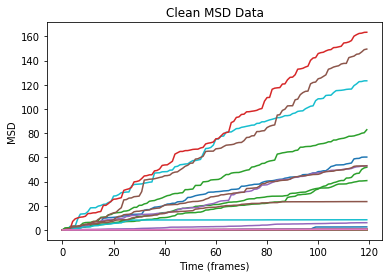

Smallest Clean MSD Array: 119, Largest Clean MDS Array: 120, Average Clean MDS Array: 119.97297297297297


In [59]:
# Getting it from mean squared distance over time
    # Here we need to find the slope of the Mean Squared Distance over Time graph m = 4D

clean_msd_arry = []

for i in mean_squared_distances:
    if i[len(i)-1] < 200:
        clean_msd_arry += [i]

for i in mean_squared_distances:
    plt.plot(i)
# plt.plot(mean_squared_distances[0])
plt.xlabel('Time (frames)')
plt.ylabel('MSD')
plt.title('Dirty MSD Data')
plt.show()
    
        
for i in clean_msd_arry:
    plt.plot(i)
plt.xlabel('Time (frames)')
plt.ylabel('MSD')
plt.title('Clean MSD Data')
plt.show()


# Now calculating the average mean squared distance: 
lengths = []
for i in clean_msd_arry:
    lengths += [len(i)]

smallest = min(lengths)
average = sum(lengths)/len(lengths)
biggest = max(lengths)

print('Smallest Clean MSD Array: {}, Largest Clean MDS Array: {}, Average Clean MDS Array: {}'.format(smallest, biggest, average))

msd_avg = []

for i in range(0, smallest):
    add_val = 0
    for j in clean_msd_arry:
        add_val += j[i]
    add_val /= len(clean_msd_arry)
    msd_avg += [add_val]

In [60]:
# Running linear regression on the overall mean squared distance vs. time
times = list(range(0, smallest))

for i in range(0, len(times)):
    times[i] = times[i]/2
    
plt.plot(times, msd_avg)
plt.xlabel('Time (frames)')
plt.ylabel('Overall Mean Squared Distance')
plt.title('Overall Clean Mean Squared Distance over Time')
plt.show()


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(times, msd_avg)

print('Slope is: {}, intercept is: {}, std error is: {}'.format(slope, intercept, std_err))
print('MSD = 4Dt so D is: {} 10^-12 m^2/s'.format(slope/4))

Slope is: 0.3765138852523293, intercept is: -0.10511427918370408, std error is: 0.0008147983316854172
MSD = 4Dt so D is: 0.09412847131308233 10^-12 m^2/s


In [52]:
'''
This cell will calculate 2Dt_est based on the maximum liklihood formula.
'''
D2t_est = 0;
N = len(msd_avg)

for i in msd_avg:
    D2t_est += i

D2t_est /= 2*N
# D2t_est is actually D because the time value is 0.5, which cancels the coefficient 2.
print('The estimated value of D is: {}'.format(D2t_est))

The estimated value of D is: 5.501022667880006


In [55]:
'''
This cell will plot the function P(r; t) with t = 0.5 (for the step size) where D is 
    1. D2t_est (from maximum liklihood formula)
    2. slope/4 (from lienar fit of MSD over time)
    3. D_est_1_opt (from direct curve fitting exercise)
'''

max_num_occ = max(values)

drs = bins[:-1]

P_max_likelihood = []
P_linear_fit = []
P_curve_fit = []

def P(r, D): # Probability density function P
    t = 0.5 # Final time value we are predicting (length of one frame)
    return ( (r/(2*D*t))*(np.exp(-(r**2)/(4*D*t))) )

for i in drs:
    P_max_likelihood += [P(i, D2t_est)]
    P_linear_fit += [P(i, slope/4)]
    P_curve_fit += [P(i, D_est_1_opt)]

plt.plot(drs, P_curve_fit)
# plt.plot(drs, P_linear_fit)
plt.plot(drs, P_max_likelihood)


plt.plot(bins[:-1], p_values, 'bo')
plt.ylabel('Probability of Occurrences')
plt.xlabel('dr Value')
plt.title('Histogram of Probability of dr Values')
plt.show()

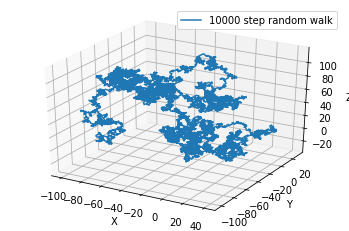

In [54]:
# Theoretical Plot for Figure 1 simulating a random walk of a particle in nDimensions
# playing around with seed for an "ideal" plot
numSeed = 99
random.seed(numSeed)
nDimensions = 3
nSteps = 10000
positions = [[0] for i in range(nDimensions)]
options = [-1, 1]

for i in range(nSteps):
    # update each dimension
    for j in range(len(positions)):
        # make a step -1 or 1 from previous position
        positions[j].append(positions[j][-1] + random.choice(options))

#plot
fig = plt.figure()
# the plot should look different for 1 and 2 dimensions
if nDimensions == 3:
    ax = fig.gca(projection='3d')
    ax.plot(positions[0], positions[1], positions[2], label="{} step random walk".format(nSteps))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
plt.savefig(fname="random_walk_3d.png", quality=95, dpi=100)

In [62]:
'''
This cell calculates our final value for k
And some useful constants for the lab
'''
bead_diameter = 1.9 # micrometers, +/- 0.1
viscosity = 1.06 # centipoise (poise = g/cms) +/- 0.05
temperature = 296.5 # kelvin, +/- 0.5

# D = kT/(gamma) | gamma is the drag coefficient 6πηr with r = radius, n = viscosity of water
gamma = 6*math.pi*0.5*bead_diameter*viscosity # = 18.98 um cP (micrometers centipoise)
# k = D (gamma)/T = k = 1.38 × 10−23J/K.
# D = 1 * 10^9 m^2 s^-1 = kT/(gamma) without scaling

def get_k(D, gamma, T):
    return ((D*gamma)/T)

k_max_l = get_k(D2t_est, gamma, temperature)
k_lin_fit = get_k(slope/4, gamma, temperature)
k_curve_fit = get_k(D_est_1_opt, gamma, temperature)

print('k max probability: {}, k lin fit: {}, k curve fit: {}'.format(k_max_l, k_lin_fit, k_curve_fit))

k max probability: 0.35216754551326646, k lin fit: 0.006025969116396885, k curve fit: [0.48509513]
